In [1]:
import numpy as np  # for numerical pyhton libraries
import pandas as pd
from scipy import stats as st

import seaborn as sns
import matplotlib.pyplot as plt  # for plotting
import numpy.matlib

In [2]:
df1 = pd.read_csv('Data/Data{}.csv'.format(1), names = ['X1', 'X2', 'X3'])
df10 = pd.read_csv('Data/Data{}.csv'.format(10), names = ['X1', 'X2', 'X3'])
df50 = pd.read_csv('Data/Data{}.csv'.format(50), names = ['X1', 'X2', 'X3'])

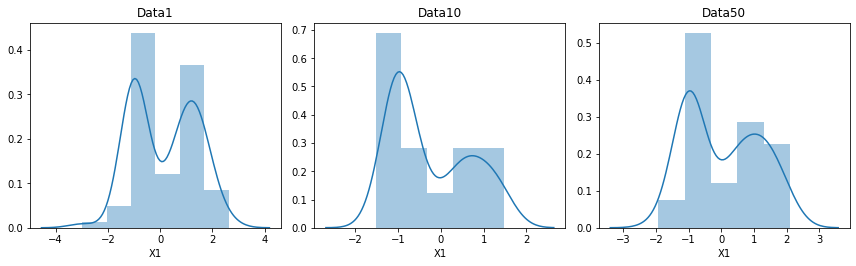

In [3]:
f, axes = plt.subplots(figsize=(12, 4), squeeze=False)
# f.suptitle('X1',size=16)
f.add_subplot(1,3,1)
sns.distplot(df1['X1'])
plt.title('Data1') 
f.add_subplot(1,3,2)
sns.distplot(df10['X1'])
plt.title('Data10') 
f.add_subplot(1,3,3)
sns.distplot(df50['X1'])
plt.title('Data50') 
axes.flat[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

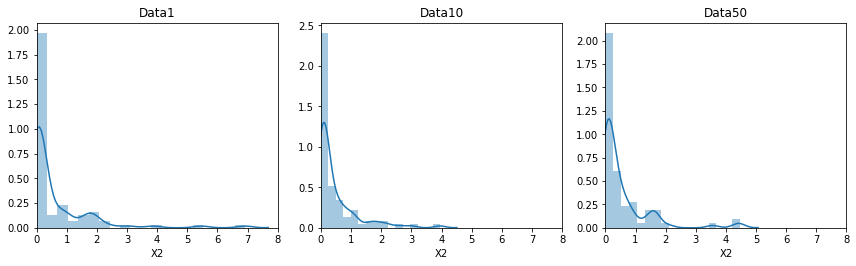

In [4]:
f, axes = plt.subplots(figsize=(12, 4), squeeze=False)
# f.suptitle('X1',size=16)
f.add_subplot(1,3,1)
sns.distplot(df1['X2'])
plt.xlim(0, 8)
plt.title('Data1') 
f.add_subplot(1,3,2)
sns.distplot(df10['X2'])
plt.xlim(0, 8)
plt.title('Data10') 
f.add_subplot(1,3,3)
sns.distplot(df50['X2'])
plt.xlim(0, 8)
plt.title('Data50') 
axes.flat[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

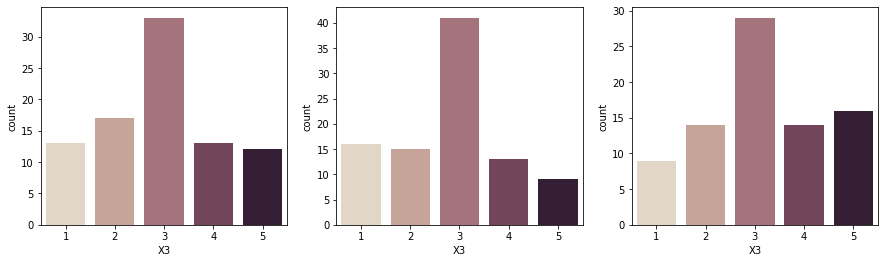

In [5]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))

sns.countplot('X3', data= df1,palette="ch:.25", ax=ax[0])
sns.countplot('X3', data= df10,palette="ch:.25", ax=ax[1])
sns.countplot('X3', data= df50,palette="ch:.25", ax=ax[2])

# fig.suptitle("Day & Month Distribution", fontsize=20)
plt.show()

In [6]:
file_length = []
for m in range(1, 51):
    
    X = pd.read_csv('Data/Data{}.csv'.format(m), names = ['x11', 'x12', 'x13'])
    file_length.append(len(X))
    

In [7]:
#create x dataframe storing all information from each sequence
S=len(file_length) #number of sequence
time_max=max(file_length)

x1=np.zeros((time_max, S))
x2=np.zeros((time_max,S))
x3=np.zeros((time_max,S))

for s in range(0,S):
    X = pd.read_csv('Data/Data{}.csv'.format(s+1), names = ['X1', 'X2', 'X3'])
    time=X.shape[0]
    x1[:time,s]=X['X1']
    x2[:time,s]=X['X2']
    x3[:time,s]=X['X3']
    

In [8]:
# for generating an initial guess
def InitialParamGuess(x1,x2,x3, K):
    
    mu = x1.mean()
    sigma = np.std(x1)
    lambd = 1/x2.mean()
    unique, counts = np.unique(x3, return_counts=True)
    cat = counts/sum(counts)
    
    # add some noise
    epsilon = 0.05
    mu *= np.sort(np.exp(epsilon * np.random.randn(K)))
    sigma *= np.exp(epsilon * np.random.randn(K))
    lambd *= np.exp(epsilon * np.random.randn(K))
    cat = np.tile(cat,(K,1))

    pi = np.ones(K) / K
    pi *= np.exp(epsilon * np.random.randn(K))
    pi /= np.sum(pi)
    
    A = np.ones((K,K)) / K
    for i in range(K):
        
        A[i,:] *= np.exp(epsilon * np.random.randn(K))
        A[i,:] /= np.sum(A[i,:])

    return pi, A, mu, sigma, lambd, cat

In [9]:
def psi1(x, mu, sigma):
    
    
    return st.norm.pdf(x,mu, sigma)
    #np.exp(-0.5* ((x-mu)/sigma)**2 ) / (np.sqrt(2*np.pi)*sigma)

In [10]:
def psi2(x,lambd):
    
    
    return lambd * np.exp(-x * lambd) 

In [11]:
def psi3(x,j, cat):
    
    return cat[j,int(x-1)]

In [12]:
def psi(x, mu, sigma, lambd, cat):
    
    # x is 3D
    
    return st.norm.pdf(x[0],mu, sigma) \
            * lambd * np.exp(-x[1] * lambd) \
            * cat[:,int(x[2]-1)]

In [13]:
def forwardFilter(X, pi, A, mu, sigma, lambd, cat):

    K = pi.shape[0]
    N = X.shape[0]
        
    alpha = np.zeros((K,N)) 
    eta = np.zeros(N) 
    
    # initialize filter
    alpha[:,0] = psi(X[0], mu, sigma, lambd, cat) * pi

    eta[0] = np.sum(alpha[:,0])        
    alpha[:,0] /= eta[0]
    
    # step forward in time    
    for t in range(1,N):
        
        alpha[:,t] = psi(X[t], mu, sigma, lambd, cat) * np.matmul( A.T,alpha[:,t-1] )
    
        eta[t] = np.sum(alpha[:,t])
        alpha[:,t] /= eta[t]
    
    return eta, alpha

In [14]:
def backwardFilter(X, eta, pi, A, mu, sigma, lambd, cat):
    
    K = pi.shape[0]
    N = X.shape[0]
    
    beta = np.zeros((K,N))
    
    beta[:,-1] = 1
    
    for t in range(N-2,-1,-1):
        beta[:,t] = np.matmul(A, beta[:,t+1] * psi(X[t+1], mu, sigma, lambd, cat) ) / eta[t+1]
        
    return beta

In [15]:
#perform the e-step
def estep(x1, x2, x3, pi, A, mu, sigma, lambd, cat,file_length):
    
    K = pi.shape[0]
    
    max_length = max(file_length)
    
    alpha = np.zeros((K, max_length,len(file_length)))
    eta = np.zeros((max_length,len(file_length)))
    beta = np.zeros((K, max_length,len(file_length)))
    gamma = np.zeros((K, max_length,len(file_length)))
    xi = np.zeros((K, K, max_length-1,len(file_length)))

    for m in range(0, len(file_length)):


        X = pd.DataFrame({'x1': x1[:,m], 'x2': x2[:,m], 'x3': x3[:,m]}).iloc[:file_length[m],:]
        X = X.values
        
        
        eta_m, alpha_m = forwardFilter(X, pi, A, mu, sigma, lambd, cat)
        eta[:len(X),m], alpha[:,:len(X),m] = eta_m, alpha_m

        beta_m = backwardFilter(X, eta_m, pi, A, mu, sigma, lambd, cat)
        beta[:,:len(X),m] = beta_m
        
        gamma[:,:,m] = alpha[:,:,m] * beta[:,:,m]
        
        for i in range(K):
            for j in range(K):

                psij = np.zeros(len(X)-1)
                psij = psi1(X[1:,0], mu[j], sigma[j])\
                        *psi2(X[1:,1],lambd[j])\
                        *np.array([psi3(x,j,cat) for x in X[1:,2]])


                xi[i,j,:len(X)-1,m] = alpha_m[i,:-1] * A[i,j] * psij * beta_m[j,1:] / eta_m[1:]
       
    return eta, gamma, xi , alpha  ,beta 




In [16]:
#perform the m-step
def mstep(x1,x2,x3, gamma, xi,file_length):
    
    K = gamma.shape[0]
    
    # update pi
    pi = np.sum(gamma[:,0,:],axis=1) #sum all time step
    pi /= np.sum(pi) #normalized the results by summing all latent' result
    
    # update A, mu, sigma, lambda
    
    A = np.zeros((K,K))
    mu = np.zeros(K)    
    sigma = np.zeros(K)
    lmbda=np.zeros(K)
    
    cat=np.zeros((K,5))   

    
    for i in range(K):
        
        #update A
        for j in range(K):
            
            #kris:
            num=0
            de=0
            for m in range(0, len(file_length)):
                if file_length[m]!=max(file_length):
                    
                    num +=np.sum(xi[i,j,: file_length[m]-1,m])
                else:
                    num +=np.sum(xi[i,j,:,m])
                de += np.sum(gamma[i,:file_length[m]-1,m])
                    
            A[i,j]=num/de
                
        #update model parameters

        nrm_fac = np.sum(gamma[i,:,:], axis = None)  #可同时用于mu, sigma, lambda的update

        mu[i] = np.sum(gamma[i,:,:] * x1, axis = None)/nrm_fac
        sigma[i] = np.sqrt(np.sum(gamma[i,:,:] * (x1-mu[i])**2, axis = None) / nrm_fac)

        lmbda[i]=nrm_fac/ np.sum(gamma[i,:,:]* x2, axis=None)

        for c in range(5):
            mask=np.array(x3==c+1)*1     #find all x3=c+1
            num=np.sum(gamma[i,:,:]* mask,axis=None)
            de=np.sum(gamma[i,:,:],axis=None)
            cat[i,c]=num/de

    return pi, A, mu, sigma,lmbda,cat

In [17]:
#perform EM:
def EM(x1,x2,x3, MAX_ITER, K):
 
    pi0, A0, mu0, sigma0, lmbda0, cat0= InitialParamGuess(x1,x2,x3, K)
    
    pi = [] 
    A = []
    mu = []
    sigma = []
    lmbda=[]
    cat=[]
    
    pi.append(pi0)
    A.append(A0)
    mu.append(mu0)
    sigma.append(sigma0)
    lmbda.append(lmbda0)
    cat.append(cat0)
    
    
    for i in range(MAX_ITER):
          
        # perform e-step
        eta, gamma, xi, alpha, beta=estep(x1, x2, x3, pi[i], A[i], mu[i], sigma[i], lmbda[i], cat[i], file_length)
        
        # peform m-step
        pi_new , A_new, mu_new, sigma_new, lmbda_new, cat_new = mstep(x1,x2,x3, gamma, xi, file_length)
        
        # add in results
        pi.append(pi_new)
        A.append(A_new)
        mu.append(mu_new)
        sigma.append(sigma_new) 
        lmbda.append(lmbda_new)
        cat.append(cat_new)

    
    return pi, A, mu, sigma, lmbda, cat



In [18]:
#using BIC to select the best model:
def BIC(K, MAX_ITER):
    
    pi, A, mu, sigma, lmbda, cat= EM(x1,x2,x3, MAX_ITER, K)
    
    S=len(file_length)
    ll=0
    
    for s in range(S):
        X = pd.read_csv('Data/Data{}.csv'.format(s+1), names = ['X1', 'X2', 'X3'])
        X = X.values
        eta,alpha=forwardFilter(X, pi[-1], A[-1], mu[-1], sigma[-1], lmbda[-1], cat[-1])

        ll+=np.sum(np.log(eta))
        
        
    d=K*(3+(5-1))+(K-1)+K*(K-1)
    bic= -ll+0.5*d * np.log(sum(file_length))
    return bic
        

Text(0.5, 0, '$Regimes$')

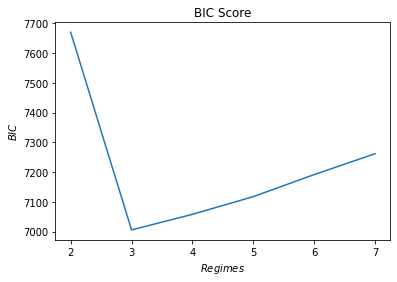

In [19]:
Kfit_list=np.arange(2,8,1)
bic_list=[]
for k in Kfit_list:
    bic_list.append(BIC(k,100))
    
 #plot the result
plt.plot(Kfit_list,bic_list)
plt.title('BIC Score')
plt.ylabel(r'$BIC$')
plt.xlabel(r'$Regimes$')

## Question3: 
From the learnt model, use the bootstrap approach to generate new samples and re-estimate the model to determine confidence bands on the learnt parameters. Generate 20 re-estimations.

In [20]:
def Simdata(pi, A, mu, sigma, lmbda, cat):
    
    time_max=max(file_length)
    S=len(file_length)

    a1=np.zeros((time_max,S))
    a2=np.zeros((time_max,S))
    a3=np.zeros((time_max,S))

    for s in range(S):

        length=file_length[s]

        Y=np.zeros(length).astype(int)
        X=np.zeros((3,length))

        cs_A = np.cumsum(A,axis=1)
        cs_pi = np.cumsum(pi)

        # draw from the prior

        
        Y[0]=np.sum(np.random.rand()>cs_pi)
        
        for t in range(length):
            
            # generate X1:normal
            X[0,t] = mu[Y[t]] + sigma[Y[t]] * np.random.randn()
            #generate x2:exp
            X[1,t] = -np.log(np.random.rand())/lmbda[Y[t]]
            #generate x3
            cs_cat=np.cumsum(cat,axis=1)
            X[2,t]=np.sum(np.random.rand()>cs_cat[Y[t]]) + 1

            # update Y
            if t < length-1:
                U = numpy.matlib.repmat(np.random.rand(),1,pi.shape[0])
                Y[t+1] = np.sum(U > cs_A[Y[t],:], axis=1) 

        a1[:length,s]=X[0,:]
        a2[:length,s]=X[1,:]
        a3[:length,s]=X[2,:]

    return a1,a2,a3 



In [21]:
#bootstrap to generate 20 new samples
pi_new=[]
A_new=[]
mu_new=[]
sigma_new=[]
lmbda_new=[]
cat_new=[]

pi0, A0, mu0, sigma0, lmbda0, cat0= EM(x1,x2,x3, 50, 3)

for i in range(20):
    
    a1,a2,a3=Simdata(pi0[-1],A0[-1],mu0[-1],sigma0[-1],lmbda0[-1],cat0[-1])
    
    pi1, A1, mu1, sigma1, lmbda1, cat1= EM(a1,a2,a3, 50, 3)

    pi_new.append(np.array([pi1[-1] for _, pi1[-1] in sorted(zip(lmbda1[-1],pi1[-1]))]))
    
    first=[A1[-1] for _, A1[-1] in sorted(zip(lmbda1[-1],A1[-1]))]
    for j in range(3):
        first[j]=[first[j] for _, first[j] in sorted(zip(lmbda1[-1],first[j]))]
    A_new.append(np.array(first))
    mu_new.append(np.array([mu1[-1] for _, mu1[-1] in sorted(zip(lmbda1[-1],mu1[-1]))]))
    sigma_new.append(np.array([sigma1[-1] for _, sigma1[-1] in sorted(zip(lmbda1[-1],sigma1[-1]))]))
    cat_new.append(np.array([cat1[-1] for _, cat1[-1] in sorted(zip(lmbda1[-1],cat1[-1]))]))
    lmbda1[-1].sort()
    lmbda_new.append(lmbda1[-1])





In [22]:
#lmbda_new

In [23]:
pi_new

[array([0.11231078, 0.6570079 , 0.23068132]),
 array([0.12759556, 0.77452331, 0.09788113]),
 array([0.25011492, 0.62051358, 0.1293715 ]),
 array([0.08680033, 0.72669948, 0.18650019]),
 array([0.08653384, 0.7385865 , 0.17487966]),
 array([0.15780421, 0.63913518, 0.20306061]),
 array([0.19847637, 0.62375236, 0.17777127]),
 array([0.0060634 , 0.18725663, 0.80667997]),
 array([0.13957856, 0.68844987, 0.17197156]),
 array([0.0859482 , 0.68579145, 0.22826035]),
 array([0.14824967, 0.73032314, 0.12142719]),
 array([0.17580397, 0.64122207, 0.18297397]),
 array([0.13494557, 0.69322342, 0.17183101]),
 array([0.19101952, 0.53591455, 0.27306592]),
 array([0.11639206, 0.66228659, 0.22132135]),
 array([0.13072403, 0.76919958, 0.10007639]),
 array([0.25367057, 0.59666599, 0.14966344]),
 array([0.16521926, 0.55626044, 0.2785203 ]),
 array([0.18736113, 0.75858893, 0.05404995]),
 array([8.92306900e-05, 7.53714502e-01, 2.46196268e-01])]

In [24]:
A_new

[array([[0.80151223, 0.09570949, 0.10277829],
        [0.49046714, 0.18946996, 0.3200629 ],
        [0.10711622, 0.19810699, 0.6947768 ]]),
 array([[0.78043687, 0.09889385, 0.12066928],
        [0.44633634, 0.24991889, 0.30374477],
        [0.11401165, 0.16466355, 0.7213248 ]]),
 array([[0.80155546, 0.09135733, 0.10708721],
        [0.54983026, 0.17965044, 0.2705193 ],
        [0.11297406, 0.18650364, 0.70052231]]),
 array([[0.79318495, 0.09394753, 0.11286752],
        [0.5490248 , 0.15335101, 0.29762419],
        [0.10782021, 0.17431646, 0.71786334]]),
 array([[0.78925823, 0.10008891, 0.11065285],
        [0.45809618, 0.19555205, 0.34635177],
        [0.12286702, 0.16931104, 0.70782194]]),
 array([[0.78828182, 0.09374693, 0.11797124],
        [0.47019732, 0.20009499, 0.32970769],
        [0.11043761, 0.17661176, 0.71295063]]),
 array([[0.79043525, 0.09621001, 0.11335474],
        [0.47325213, 0.23316877, 0.2935791 ],
        [0.10837757, 0.2005985 , 0.69102393]]),
 array([[0.53178728,

In [25]:
sigma_new

[array([0.0996137, 1.0355728, 0.4952555]),
 array([0.10208738, 1.10089785, 0.47715188]),
 array([0.09921287, 1.02598061, 0.47486305]),
 array([0.10343096, 1.05309718, 0.50405743]),
 array([0.10145041, 1.02865753, 0.49830665]),
 array([0.10156376, 1.03885704, 0.50678805]),
 array([0.10219675, 1.03070201, 0.48366765]),
 array([0.08779254, 0.12822558, 0.84126852]),
 array([0.10223811, 1.04814978, 0.49810795]),
 array([0.10025418, 1.05159207, 0.48948751]),
 array([0.10039967, 1.05398142, 0.48275559]),
 array([0.10197212, 1.07242427, 0.48937605]),
 array([0.1038918 , 1.04242754, 0.5065164 ]),
 array([0.10110827, 1.01167353, 0.5036021 ]),
 array([0.10151794, 0.97256607, 0.51052367]),
 array([0.10203486, 1.01334345, 0.48310641]),
 array([0.10233972, 1.05242555, 0.50392984]),
 array([0.10183646, 1.03291043, 0.48397431]),
 array([0.10296225, 1.06476218, 0.48737049]),
 array([0.10061231, 1.01109554, 0.48458062])]

In [26]:
cat_new

[array([[9.65699038e-02, 1.94418342e-01, 7.08360782e-01, 1.10819481e-11,
         6.50971513e-04],
        [2.53376596e-13, 5.11721630e-10, 2.55679519e-01, 5.00389101e-01,
         2.43931380e-01],
        [2.12662929e-01, 2.09298447e-01, 1.85261739e-01, 2.10692164e-01,
         1.82084722e-01]]),
 array([[1.01069971e-01, 2.03241930e-01, 6.95688099e-01, 3.57472112e-15,
         1.05105370e-21],
        [8.71785436e-05, 5.29934855e-08, 2.47297209e-01, 4.60772490e-01,
         2.91843070e-01],
        [2.11116633e-01, 1.97007325e-01, 1.90151508e-01, 2.15699990e-01,
         1.86024545e-01]]),
 array([[8.97259048e-02, 1.97597003e-01, 7.12677081e-01, 1.04047712e-08,
         1.24615152e-29],
        [9.40005470e-10, 4.69715019e-03, 2.10933386e-01, 5.09564560e-01,
         2.74804904e-01],
        [2.09222621e-01, 2.13800785e-01, 1.69144354e-01, 2.17728432e-01,
         1.90103808e-01]]),
 array([[1.10725823e-01, 1.92681511e-01, 6.96592667e-01, 6.19780356e-17,
         2.28255929e-25],
    

#### Pi CI

In [27]:
sample=len(pi_new)
pi1=np.empty(sample)
pi2=np.empty(sample)
pi3=np.empty(sample)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)

pi_ci_dict = {}
for i in range(sample):
    
    pi1[i]=pi_new[i][0]
    pi_ci_dict['pi1_ci']=[pi1.mean()-t*pi1.std()/n, pi1.mean()+t*pi1.std()/n]
    
    pi2[i]=pi_new[i][1]
    pi_ci_dict['pi2_ci']=[pi2.mean()-t*pi2.std()/n, pi2.mean()+t*pi2.std()/n]
    
    pi3[i]=pi_new[i][2]
    pi_ci_dict['pi3_ci']=[pi3.mean()-t*pi3.std()/n, pi3.mean()+t*pi3.std()/n]




#### Mu CI

In [28]:
sample=len(mu_new)
mu1=np.empty(sample)
mu2=np.empty(sample)
mu3=np.empty(sample)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)

mu_ci_dict = {}
for i in range(sample):
    
    mu1[i]=mu_new[i][0]
    mu_ci_dict['mu1_ci']=[mu1.mean()-t*mu1.std()/n, mu1.mean()+t*mu1.std()/n]
    
    mu2[i]=mu_new[i][1]
    mu_ci_dict['mu2_ci']=[mu2.mean()-t*mu2.std()/n, mu2.mean()+t*mu2.std()/n]
    
    mu3[i]=mu_new[i][2]
    mu_ci_dict['mu3_ci']=[mu3.mean()-t*mu3.std()/n, mu3.mean()+t*mu3.std()/n]


#### Sigma CI

In [29]:
sample=len(sigma_new)
sigma1=np.empty(sample)
sigma2=np.empty(sample)
sigma3=np.empty(sample)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)
sigma_ci_dict = {}
for i in range(sample):
    
    sigma1[i]=sigma_new[i][0]
    sigma_ci_dict['sigma1_ci']=[sigma1.mean()-t*sigma1.std()/n, sigma1.mean()+t*sigma1.std()/n]
    
    sigma2[i]=sigma_new[i][1]
    sigma_ci_dict['sigma2_ci']=[sigma2.mean()-t*sigma2.std()/n, sigma2.mean()+t*sigma2.std()/n]
    
    sigma3[i]=sigma_new[i][2]
    sigma_ci_dict['sigma3_ci']=[sigma3.mean()-t*sigma3.std()/n, sigma3.mean()+t*sigma3.std()/n]



#### Lambda CI

In [30]:
sample=len(lmbda_new)
lmbda1=np.empty(sample)
lmbda2=np.empty(sample)
lmbda3=np.empty(sample)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)

lambda_ci_dict = {}
for i in range(sample):
    
    lmbda1[i]=lmbda_new[i][0]
    lambda_ci_dict['lmbda1_ci']=[lmbda1.mean()-t*lmbda1.std()/n, lmbda1.mean()+t*lmbda1.std()/n]
    
    lmbda2[i]=lmbda_new[i][1]
    lambda_ci_dict['lmbda2_ci']=[lmbda2.mean()-t*lmbda2.std()/n, lmbda2.mean()+t*lmbda2.std()/n]
    
    lmbda3[i]=lmbda_new[i][2]
    lambda_ci_dict['lmbda3_ci']=[lmbda3.mean()-t*lmbda3.std()/n, lmbda3.mean()+t*lmbda3.std()/n]




/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


#### A CI

In [31]:
sample=len(A_new)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)


A_ci_dict = {}
    
for j in range(3):

    for k in range(3):
        
        Ah = np.empty(sample)
        
        for i in range(sample):
            
            
            Ah[i] = A_new[i][j][k]
            
            A_ci_dict['A{}{}_ci'.format(j+1,k+1)] = [Ah.mean()-t*Ah.std()/n, Ah.mean()+t*Ah.std()/n]
            
            

#### cat CI

In [32]:
sample=len(cat_new)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)


cat_ci_dict = {}
    
for j in range(3):

    for k in range(5):
        
        cath = np.empty(sample)
        
        for i in range(sample):
            
            
            cath[i] = cat_new[i][j][k]
            
            cat_ci_dict['cat{}{}_ci'.format(j+1,k+1)] = [cath.mean()-t*cath.std()/n, cath.mean()+t*cath.std()/n]
            
            

In [33]:
ci=[pi_ci_dict,A_ci_dict,mu_ci_dict, sigma_ci_dict,lambda_ci_dict,cat_ci_dict]
name=['pi','A','mu','sigma','lambda','categorical']

for i in range(len(ci)):
    print('The Confidence Interval at 95% sigfinicance level for '+ name[i])
    print(ci[i])
    print('--- ** ---')

The Confidence Interval at 95% sigfinicance level for pi
{'pi1_ci': [0.10754425394934725, 0.16792586344958266], 'pi2_ci': [0.5929666177627843, 0.71094492898471], 'pi3_ci': [0.14086272611248069, 0.2797556097410952]}
--- ** ---
The Confidence Interval at 95% sigfinicance level for A
{'A11_ci': [0.7530137784908522, 0.8070232939644624], 'A12_ci': [0.08806444640389038, 0.114197434544003], 'A13_ci': [0.1043628775210177, 0.13333816907577423], 'A21_ci': [0.4835129554337037, 0.5214511258781936], 'A22_ci': [0.18346012991744054, 0.21451932023130194], 'A23_ci': [0.2732891585113476, 0.3237673100280126], 'A31_ci': [0.10975919809297154, 0.11895367290633331], 'A32_ci': [0.16418184977556805, 0.19075843782987273], 'A33_ci': [0.6979775040907785, 0.7183693373044757]}
--- ** ---
The Confidence Interval at 95% sigfinicance level for mu
{'mu1_ci': [-1.002405325094164, -1.0004250548926459], 'mu2_ci': [-0.1381315004250269, 0.07814505618560336], 'mu3_ci': [0.9822760421295988, 1.043649530801665]}
--- ** ---
The 

In [34]:
pi0, A0, mu0, sigma0, lmbda0, cat0= EM(x1,x2,x3, 50, 3)

## Here is the results from the original sample

In [35]:
[pi0[-1] for _, pi0[-1] in sorted(zip(lmbda0[-1],pi0[-1]))]

[0.15150442341499443, 0.6602841227860197, 0.18821145379898593]

In [36]:
[mu0[-1] for _, mu0[-1] in sorted(zip(lmbda0[-1],mu0[-1]))]

[-1.0012531731119283, 0.013211523728079698, 1.0230260221315222]

In [37]:
[sigma0[-1] for _,sigma0[-1] in sorted(zip(lmbda0[-1],sigma0[-1]))]

[0.10161190518696545, 1.0364040766782945, 0.49580387130245945]

In [38]:
[cat0[-1] for _, cat0[-1] in sorted(zip(lmbda0[-1],cat0[-1]))]

[array([1.02179267e-01, 1.95341799e-01, 7.02478934e-01, 9.82326327e-12,
        2.50294637e-14]),
 array([2.48090423e-14, 1.63901883e-05, 2.46852513e-01, 4.82840038e-01,
        2.70291059e-01]),
 array([0.20244431, 0.20895456, 0.19067341, 0.2101561 , 0.18777163])]

In [39]:
a=[A0[-1] for _, A0[-1] in sorted(zip(lmbda0[-1],A0[-1]))]

In [40]:
for j in range(3):
    a[j]=[a[j] for _, a[j] in sorted(zip(lmbda0[-1],a[j]))]
   

In [41]:
a #transaction metix  with the right order

[[0.7933741426618205, 0.09238775636326198, 0.1142381009749175],
 [0.5005360170385047, 0.19460110965128638, 0.3048628733102091],
 [0.11184202974823912, 0.1863608321499729, 0.7017971381017878]]

In [42]:
A_ci_dict

{'A11_ci': [0.7530137784908522, 0.8070232939644624],
 'A12_ci': [0.08806444640389038, 0.114197434544003],
 'A13_ci': [0.1043628775210177, 0.13333816907577423],
 'A21_ci': [0.4835129554337037, 0.5214511258781936],
 'A22_ci': [0.18346012991744054, 0.21451932023130194],
 'A23_ci': [0.2732891585113476, 0.3237673100280126],
 'A31_ci': [0.10975919809297154, 0.11895367290633331],
 'A32_ci': [0.16418184977556805, 0.19075843782987273],
 'A33_ci': [0.6979775040907785, 0.7183693373044757]}

In [43]:
np.sort(lmbda0[-1])

array([ 0.98856952,  5.03182338, 19.3879046 ])